# Оценка стоимости автомобилей

## Описание проетка

Компания "Не бит, не крашен" занимается продажей автомобилей и решила привлечь новых клиентов с помощью создания новой функции. Ее задача предсказывать примерную стоимость автомобиля на основе вводимых пользователем характеристик. Для этого необходимо построить и обучить модель, соответствующую требованиям заказчика, которые включают в себя качество предсказания, время обучения модели и время предсказания модели.

## Описание данных

Данные предоставили в файле с одной таблицей - /datasets/autos.csv.  
Рассмотрим его признаки:
* DateCrawled — дата скачивания анкеты из базы
* VehicleType — тип автомобильного кузова
* RegistrationYear — год регистрации автомобиля
* Gearbox — тип коробки передач
* Power — мощность (л. с.)
* Model — модель автомобиля
* Kilometer — пробег (км)
* RegistrationMonth — месяц регистрации автомобиля
* FuelType — тип топлива
* Brand — марка автомобиля
* Repaired — была машина в ремонте или нет
* DateCreated — дата создания анкеты
* NumberOfPictures — количество фотографий автомобиля
* PostalCode — почтовый индекс владельца анкеты (пользователя)
* LastSeen — дата последней активности пользователя
* Price — цена (евро). ***Целевой признак***

## Задача проекта

На основе имеющихся данных требуется разработать модель, способную прогнозировать цену автомобиля на основе его характеристик. Это обеспечит удобство при продаже или покупке автомобилей и поспособствует привлечению новых клиентов

## Установка и импорт библиотек

In [1]:
!pip install pandas
!pip show numpy
!pip install -U scikit-learn
!pip install lightgbm

Name: numpy
Version: 1.21.1
Summary: NumPy is the fundamental package for array computing with Python.
Home-page: https://www.numpy.org
Author: Travis E. Oliphant et al.
Author-email: None
License: BSD
Location: /opt/conda/lib/python3.9/site-packages
Requires: 
Required-by: xgboost, transformers, thinc, tensorflow-cpu, tensorboard, statsmodels, spacy, seaborn, scipy, scikit-learn, pyod, pyarrow, patsy, pandas, opt-einsum, numba, matplotlib, lightgbm, Keras-Preprocessing, h5py, gensim, folium, catboost, blis


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.preprocessing import OrdinalEncoder
from sklearn.linear_model import LinearRegression
import scipy as sp
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import  KFold
from sklearn.metrics import make_scorer, mean_squared_error
from lightgbm import LGBMRegressor
import time
from sklearn.dummy import DummyRegressor

## Используемые функции

In [3]:
# Вывод различной информации о таблице
def analiz(df, cat_per):
    df.info()
    print()
    display(df.describe())
    print()
    print('Кол-во пропусков в таблице')
    display(df.isna().sum())
    print()
    print('Кол-во дубликатов в таблице')
    display(df.duplicated().sum())
    print()
    print('Проверка на неявные дубликаты')
    if len(cat_per) == 0:
        print('Нечего проверять')
    for i in cat_per:
        print(i, df[i].unique())
        print()


# Оптимизация числовых типов данных
def optimize_memory_usage(df: pd.DataFrame, print_size: bool=True) -> pd.DataFrame:
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64'] # Типы, которые будем проверять на оптимизацию
    # Размер занимаемой памяти до оптимизации (в Мб)
    before_size = df.memory_usage().sum() / 1024**2    
    for column in df.columns:
        column_type = df[column].dtypes
        if column_type in numerics:
            column_min = df[column].min()
            column_max = df[column].max()
            if str(column_type).startswith('int'):
                if column_min > np.iinfo(np.int8).min and column_max < np.iinfo(np.int8).max:
                    df[column] = df[column].astype(np.int8)
                elif column_min > np.iinfo(np.int16).min and column_max < np.iinfo(np.int16).max:
                    df[column] = df[column].astype(np.int16)
                elif column_min > np.iinfo(np.int32).min and column_max < np.iinfo(np.int32).max:
                    df[column] = df[column].astype(np.int32)
                elif column_min > np.iinfo(np.int64).min and column_max < np.iinfo(np.int64).max:
                    df[column] = df[column].astype(np.int64)  
            else:
                if column_min > np.finfo(np.float32).min and column_max < np.finfo(np.float32).max:
                    df[column] = df[column].astype(np.float32)
                else:
                    df[column] = df[column].astype(np.float64)    
    # Размер занимаемой памяти после оптимизации (в Мб)
    after_size = df.memory_usage().sum() / 1024**2
    if print_size: print('Размер использования памяти: до {:5.2f} Mb - после {:5.2f} Mb ({:.1f}%)'
                         .format(before_size, after_size, 100 * (before_size - after_size) / before_size))
    return df



# Функция для построения гистограмм и ящиков с усами для каждого признака
def numbers_plot(df, param_hue):
    sns.set(font_scale=1.2)
    numerical_columns = df.select_dtypes(include='number').columns
    fig, axs = plt.subplots(len(numerical_columns), 2, figsize=(11, 14))
    
    for i in range(len(numerical_columns)):
        column = numerical_columns[i]
        if column in ['registration_month']:
            sns.countplot(data = df, x = column, ax = axs[i, 0])
            axs[i, 0].set_title(column)
        else:
            sns.histplot(data = df, x = column, hue=param_hue, ax = axs[i, 0], stat='density', common_norm=False)
            axs[i, 0].set_title(column)
        
        sns.boxplot(x = df[column], ax = axs[i, 1])
        axs[i, 1].set_title(column)
    
    plt.tight_layout()
    plt.show()


# Функция для расчета границ выбросов
def borders(df, column):
    # Рассчитаем первый и третий квантили
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    # Межквартальный размах
    dQ = Q3 - Q1
    # Границы выбросов
    Q1_del = Q1 - dQ * 1.5
    print('Нижняя граница выбросов: ', Q1_del)
    Q3_del = Q3 + dQ * 1.5
    print('Верхняя граница выбросов: ', Q3_del)



# Изображает категориальные признаки в виде столбчатых диаграмм
def kategory_col(df, columns):
    sns.set(style='whitegrid')
    sns.set_palette('pastel')
    for column in columns:
        count = len(autos[column].unique())
        if count > 20:
            plt.figure(figsize=(4, 4))
            df[column].value_counts().head().plot(kind='pie', autopct='%1.0f%%')
            plt.title(f"Распределение Топ-5 категорий у {column}")
            plt.show()
        else:
            plt.figure(figsize=(4, 4))
            df[column].value_counts().plot(kind='pie', autopct='%1.0f%%')
            plt.title(column)
            plt.show()

## Загрузка данных

Посмотрим на данные, которые нам предоставили

In [4]:
import os

dtf1 = 'autos.csv'
dtf2 = '/datasets/autos.csv'

if os.path.exists(dtf1):
    autos = pd.read_csv(dtf1)
    display(autos.head())
elif os.path.exists(dtf2):
    autos = pd.read_csv(dtf2)
    display(autos.head())
else:
    print('file read error')

'''
try:
    autos = pd.read_csv('autos.csv')
    display(autos.head())
except:
    autos = pd.read_csv('/datasets/autos.csv')
    display(autos.head())
'''

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21


"\ntry:\n    autos = pd.read_csv('autos.csv')\n    display(autos.head())\nexcept:\n    autos = pd.read_csv('/datasets/autos.csv')\n    display(autos.head())\n"

На первый взгляд можно подчеркнуть, что названия признаков с большой буквы. Лучше их привести к нижнему регистру. В некоторых столбцах уже видны пропуски. Имеются странные нули в некоторых столбцах, как Power, RegistrationMonth и возможно еще. Видимо это пропуски, которые сделали, чтобы столбик не был типа object. Такие данные можно считать неинформативными. Нас предупреждали, что такое возможно и их нужно будет удалить

## Предобработка данных

Для начала приведем к нижнему регистру названия столбиков и заменим слитное написание раздельных слов на _

In [5]:
autos.columns = autos.columns.str.lower()
autos.columns = ['date_crawled', 'price', 'vehicle_type', 'registration_year', 'gearbox',
       'power', 'model', 'kilometer', 'registration_month', 'fuel_type', 'brand',
       'repaired', 'date_created', 'number_of_pictures', 'postal_code',
       'lastseen']
autos.columns

Index(['date_crawled', 'price', 'vehicle_type', 'registration_year', 'gearbox',
       'power', 'model', 'kilometer', 'registration_month', 'fuel_type',
       'brand', 'repaired', 'date_created', 'number_of_pictures',
       'postal_code', 'lastseen'],
      dtype='object')

Теперь посмотрим на информацию, типы столбцов, пропуски и дубликаты. таблицы с помощью функции analiz

In [6]:
cat_per = ['vehicle_type', 'gearbox', 'registration_month', 'fuel_type', 'brand', 'repaired', 'number_of_pictures', 'kilometer', 'registration_year']
analiz(autos, cat_per)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column              Non-Null Count   Dtype 
---  ------              --------------   ----- 
 0   date_crawled        354369 non-null  object
 1   price               354369 non-null  int64 
 2   vehicle_type        316879 non-null  object
 3   registration_year   354369 non-null  int64 
 4   gearbox             334536 non-null  object
 5   power               354369 non-null  int64 
 6   model               334664 non-null  object
 7   kilometer           354369 non-null  int64 
 8   registration_month  354369 non-null  int64 
 9   fuel_type           321474 non-null  object
 10  brand               354369 non-null  object
 11  repaired            283215 non-null  object
 12  date_created        354369 non-null  object
 13  number_of_pictures  354369 non-null  int64 
 14  postal_code         354369 non-null  int64 
 15  lastseen            354369 non-null  object
dtypes:

,price,registration_year,power,kilometer,registration_month,number_of_pictures,postal_code
count,354369.000000,354369.000000,354369.000000,354369.000000,354369.000000,354369.0,354369.000000
mean,4416.656776,2004.234448,110.094337,128211.172535,5.714645,0.0,50508.689087
std,4514.158514,90.227958,189.850405,37905.341530,3.726421,0.0,25783.096248
min,0.000000,1000.000000,0.000000,5000.000000,0.000000,0.0,1067.000000
25%,1050.000000,1999.000000,69.000000,125000.000000,3.000000,0.0,30165.000000
50%,2700.000000,2003.000000,105.000000,150000.000000,6.000000,0.0,49413.000000
75%,6400.000000,2008.000000,143.000000,150000.000000,9.000000,0.0,71083.000000
max,20000.000000,9999.000000,20000.000000,150000.000000,12.000000,0.0,99998.000000



Кол-во пропусков в таблице


date_crawled              0
price                     0
vehicle_type          37490
registration_year         0
gearbox               19833
power                     0
model                 19705
kilometer                 0
registration_month        0
fuel_type             32895
brand                     0
repaired              71154
date_created              0
number_of_pictures        0
postal_code               0
lastseen                  0
dtype: int64


Кол-во дубликатов в таблице


4


Проверка на неявные дубликаты
vehicle_type [nan 'coupe' 'suv' 'small' 'sedan' 'convertible' 'bus' 'wagon' 'other']

gearbox ['manual' 'auto' nan]

registration_month [ 0  5  8  6  7 10 12 11  2  3  1  4  9]

fuel_type ['petrol' 'gasoline' nan 'lpg' 'other' 'hybrid' 'cng' 'electric']

brand ['volkswagen' 'audi' 'jeep' 'skoda' 'bmw' 'peugeot' 'ford' 'mazda'
 'nissan' 'renault' 'mercedes_benz' 'opel' 'seat' 'citroen' 'honda' 'fiat'
 'mini' 'smart' 'hyundai' 'sonstige_autos' 'alfa_romeo' 'subaru' 'volvo'
 'mitsubishi' 'kia' 'suzuki' 'lancia' 'toyota' 'chevrolet' 'dacia'
 'daihatsu' 'trabant' 'saab' 'chrysler' 'jaguar' 'daewoo' 'porsche'
 'rover' 'land_rover' 'lada']

repaired [nan 'yes' 'no']

number_of_pictures [0]

kilometer [150000 125000  90000  40000  30000  70000   5000 100000  60000  20000
  80000  50000  10000]

registration_year [1993 2011 2004 2001 2008 1995 1980 2014 1998 2005 1910 2016 2007 2009
 2002 2018 1997 1990 2017 1981 2003 1994 1991 1984 2006 1999 2012 2010
 2000 1992 

Переделаем столбцы с датой в тип datetime и оптимизируем с помощью функции optimize_memory_usage

In [7]:
autos['date_crawled'] = pd.to_datetime(autos['date_crawled'], format='%Y-%m-%d %H:%M:%S')
autos['date_created'] = pd.to_datetime(autos['date_created'], format='%Y-%m-%d %H:%M:%S')
autos['lastseen'] = pd.to_datetime(autos['lastseen'], format='%Y-%m-%d %H:%M:%S')
print(autos.info())
print()
optimize_memory_usage(autos)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column              Non-Null Count   Dtype         
---  ------              --------------   -----         
 0   date_crawled        354369 non-null  datetime64[ns]
 1   price               354369 non-null  int64         
 2   vehicle_type        316879 non-null  object        
 3   registration_year   354369 non-null  int64         
 4   gearbox             334536 non-null  object        
 5   power               354369 non-null  int64         
 6   model               334664 non-null  object        
 7   kilometer           354369 non-null  int64         
 8   registration_month  354369 non-null  int64         
 9   fuel_type           321474 non-null  object        
 10  brand               354369 non-null  object        
 11  repaired            283215 non-null  object        
 12  date_created        354369 non-null  datetime64[ns]
 13  number_of_pictures  354369 no

,date_crawled,price,vehicle_type,registration_year,gearbox,power,model,kilometer,registration_month,fuel_type,brand,repaired,date_created,number_of_pictures,postal_code,lastseen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31,0,60437,2016-04-06 10:17:21
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
354364,2016-03-21 09:50:58,0,NaN,2005,manual,0,colt,150000,7,petrol,mitsubishi,yes,2016-03-21,0,2694,2016-03-21 10:42:49
354365,2016-03-14 17:48:27,2200,NaN,2005,NaN,0,NaN,20000,1,NaN,sonstige_autos,NaN,2016-03-14,0,39576,2016-04-06 00:46:52
354366,2016-03-05 19:56:21,1199,convertible,2000,auto,101,fortwo,125000,3,petrol,smart,no,2016-03-05,0,26135,2016-03-11 18:17:12
354367,2016-03-19 18:57:12,9200,bus,1996,manual,102,transporter,150000,3,gasoline,volkswagen,no,2016-03-19,0,87439,2016-04-07 07:15:26


Изменили типы данных у двух столбцов с датами на datetime64[ns]. Оптимизация ничего не упростила. Нам дали очень хорошие данные. Идем дальше

С помощью функции describe() мы так же увидли информацию о таблице, но немного другую. Тут уже больше видны выбросы или какие-то нестандартные значеиня. В столбце с годом регистрации автомобиля это 9999 и 1000 годы. В мощности машины - 20000 л.с. слишком много. И самый странный столбец это number_of_pictures, т.к. в нем одни нули. Это очень странно, видимо, его прийдется удалить

In [8]:
autos = autos.drop('number_of_pictures', axis = 1)
autos.head()

,date_crawled,price,vehicle_type,registration_year,gearbox,power,model,kilometer,registration_month,fuel_type,brand,repaired,date_created,postal_code,lastseen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31,60437,2016-04-06 10:17:21


Удалим неявные дубликаты, которые можно было заметить в уникальных значениях признаков в fuel_type это 'gasoline' и 'petrol', а в model - 'rangerover' и 'range_rover'

In [9]:
autos['fuel_type'] = autos['fuel_type'].replace({'gasoline': 'petrol'})
autos['model'] = autos['fuel_type'].replace({'rangerover': 'range_rover'})

Перейдем к пропускам. Тут их достаточно много. В vehicle_type - 37490, gearbox - 19833, model - 19705, fuel_type - 32895, repaired - 71154. Чтобы определить, что с ними делать, посмотрим на то сколько процентов от общего кол-ва данных они занимают

In [10]:
all = len(autos)

vehicle_type = 37490
vehicle_type_pr = vehicle_type * 100 / all
print(f"vehicle_type_pr: {vehicle_type_pr}")

gearbox = 19833
gearbox_pr = gearbox * 100 / all
print(f"gearbox_pr: {gearbox_pr}")

model = 19705
model_pr = model * 100 / all
print(f"model_pr: {model_pr}")

fuel_type = 32895
fuel_type_pr = fuel_type * 100 / all
print(f"fuel_type_pr: {fuel_type_pr}")

repaired = 71154
repaired_pr = repaired * 100 / all
print(f"repaired_pr: {repaired_pr}")

vehicle_type_pr: 10.57936783409384
gearbox_pr: 5.596708515699737
model_pr: 5.560587974681758
fuel_type_pr: 9.282696849893755
repaired_pr: 20.07907012182217


В vehicle_type достаточно много пропусков, поэтому просто удалить значения не получится. Лучшим решением остается заполнить пропуски самым часто встречающимся значением.  
gearbox_pr - около 5% пропусков. Тут тоже заполним медианой, т.к. всего два варианта АКПП и МКПП. По логике медианой будет АКПП, но мы это проверим.  
У model_pr тоже около 5% пропусков. Здесь уже большая вариативность, т.к. марок машин много. Строчки с пропусками от этого столбца лучше удалить.  
В fuel_type_pr 9% пропусков. Типов топлива не так много, а пропусков - не мало, поэтому их лучше заполнить медианой.  
repaired_pr имеет 20% пропусков. Тоже заполним медианой  
Начнем с model_pr, потому что при удалении строк могут удалиться и другие пропуски

In [11]:
'''
print(autos['model'].isna().sum())
autos = autos.dropna(subset = 'model')
print(autos['model'].isna().sum())
'''

autos['model'] = autos['model'].fillna('Nun')
print(autos['model'].isna().sum())

0


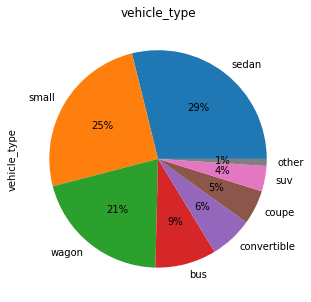

In [12]:
plt.figure(figsize=(5, 5))
autos['vehicle_type'].value_counts().plot(kind='pie', autopct='%1.0f%%')
plt.title('vehicle_type')
plt.show()

На самом деле все не так очевидно, потому что sedan не прям явно выделяется от small, а wagon не знаю что это и почему их так много. Лучше заполнить пропуски просто sedan.

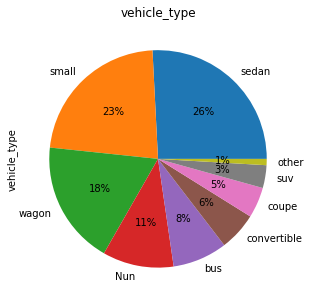

In [13]:
autos['vehicle_type'] = autos['vehicle_type'].fillna('Nun')
plt.figure(figsize=(5, 5))
autos['vehicle_type'].value_counts().plot(kind='pie', autopct='%1.0f%%')
plt.title('vehicle_type')
plt.show()

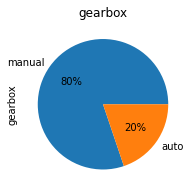

In [14]:
plt.figure(figsize=(3, 3))
autos['gearbox'].value_counts().plot(kind='pie', autopct='%1.0f%%')
plt.title('gearbox')
plt.show()

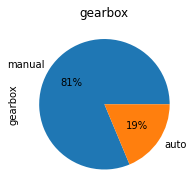

In [15]:
autos['gearbox'] = autos['gearbox'].fillna('manual')
plt.figure(figsize=(3, 3))
autos['gearbox'].value_counts().plot(kind='pie', autopct='%1.0f%%')
plt.title('gearbox')
plt.show()

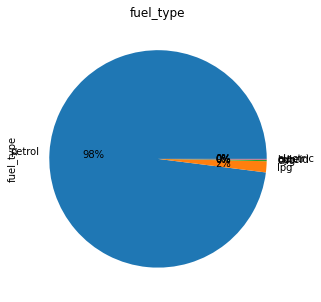

In [16]:
plt.figure(figsize=(5, 5))
autos['fuel_type'].value_counts().plot(kind='pie', autopct='%1.0f%%')
plt.title('fuel_type')
plt.show()

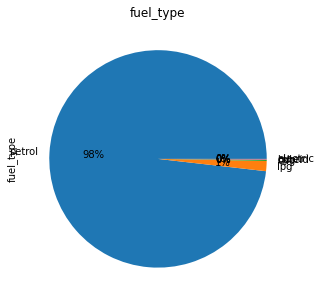

In [17]:
autos['fuel_type'] = autos['fuel_type'].fillna('petrol')
plt.figure(figsize=(5, 5))
autos['fuel_type'].value_counts().plot(kind='pie', autopct='%1.0f%%')
plt.title('fuel_type')
plt.show()

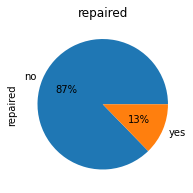

In [18]:
plt.figure(figsize=(3, 3))
autos['repaired'].value_counts().plot(kind='pie', autopct='%1.0f%%')
plt.title('repaired')
plt.show()

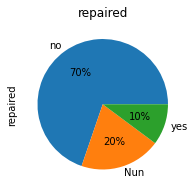

In [19]:
autos['repaired'] = autos['repaired'].fillna('Nun')
plt.figure(figsize=(3, 3))
autos['repaired'].value_counts().plot(kind='pie', autopct='%1.0f%%')
plt.title('repaired')
plt.show()

In [20]:
autos.isna().sum()

date_crawled          0
price                 0
vehicle_type          0
registration_year     0
gearbox               0
power                 0
model                 0
kilometer             0
registration_month    0
fuel_type             0
brand                 0
repaired              0
date_created          0
postal_code           0
lastseen              0
dtype: int64

Все пропуски закрыли.  
Не забываем, что у нас есть категориальные признаки, в которых есть странные нули. Обработаем их в выбросах.  
А сейчас посмотрим на дубликаты. Их оказалось 4 штуки - нужно удалить

In [21]:
autos = autos.drop_duplicates()
print(autos.duplicated().sum())

0


Явных дубликатов не было замечено

теперь посмотрим скольно неинформативных данных

In [22]:
autos.head()

,date_crawled,price,vehicle_type,registration_year,gearbox,power,model,kilometer,registration_month,fuel_type,brand,repaired,date_created,postal_code,lastseen
0,2016-03-24 11:52:17,480,Nun,1993,manual,0,petrol,150000,0,petrol,volkswagen,Nun,2016-03-24,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,petrol,125000,5,petrol,audi,yes,2016-03-24,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,petrol,125000,8,petrol,jeep,Nun,2016-03-14,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,petrol,150000,6,petrol,volkswagen,no,2016-03-17,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,petrol,90000,7,petrol,skoda,no,2016-03-31,60437,2016-04-06 10:17:21


In [23]:
print(f"price: {(autos['price'] == 0).sum()}")
print(f"price: {(autos['registration_year'] == 0).sum()}")
print(f"price: {(autos['power'] == 0).sum()}")
print(f"price: {(autos['registration_month'] == 0).sum()}")
print(f"price: {(autos['postal_code'] == 0).sum()}")

price: 10772
price: 0
price: 40225
price: 37352
price: 0


Достаточно много значений прийдется удалить, но что поделать

In [24]:
autos = autos[autos['price'] > 700]
print(f"price: {(autos['price'] == 0).sum()}")

price: 0


In [25]:
autos = autos[autos['power'] != 0]

In [26]:
autos = autos.drop('registration_month', axis = 1)
autos = autos.drop('postal_code', axis = 1)
autos.head()

,date_crawled,price,vehicle_type,registration_year,gearbox,power,model,kilometer,fuel_type,brand,repaired,date_created,lastseen
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,petrol,125000,petrol,audi,yes,2016-03-24,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,petrol,125000,petrol,jeep,Nun,2016-03-14,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,petrol,150000,petrol,volkswagen,no,2016-03-17,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,petrol,90000,petrol,skoda,no,2016-03-31,2016-04-06 10:17:21
6,2016-04-01 20:48:51,2200,convertible,2004,manual,109,petrol,150000,petrol,peugeot,no,2016-04-01,2016-04-05 18:18:39


Подведем итоги нашего достаточно объемного шага. Мы переименовали названия столбцов в таблице. С помощью функции analiz смогли посмотреть на информацию о таблице. Изменили типы данных, обработали пропуски с помощью различных методов, удалили дубликаты и строки с неинформативными значениями

## Подготовка к обучению модели

Перейдем к визуальному представлению данных. Через гистограммы и ящики с усами. В этом нам поможет функция numbers_plot

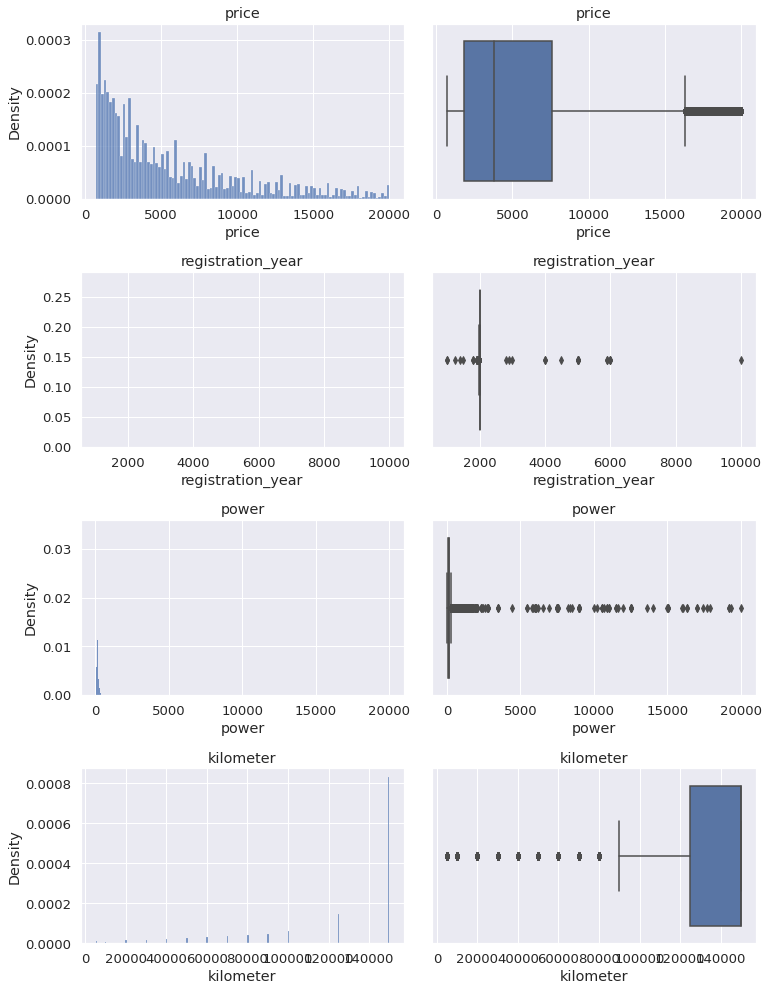

In [28]:
numbers_plot(autos, param_hue=None)

На некоторых гистограммах такие далекие выбросы, что невозможно график разглядеть! От этого нужно избавляться. Но по ящикам с усами даже не увидеть квартили. Разобраться в этом нам поможет функция borders(), которая посчитает границы выбросов за нас. У price мы оставим все значения тк их слишком много выходит за пределы min и max ящика с усами, а нам столько удалять нельзя. Еще они лежат в пределах разумного. В power возьмем границы не до 257, а до 350, и не будем удалять значения kilometer, которые меньше 87500, т.к. такие машины могут быть

In [29]:
before = len(autos)

In [30]:
print('registration_year')
borders(autos, 'registration_year')
print()
print('power')
borders(autos, 'power')
print()
print('kilometer')
borders(autos, 'kilometer')

registration_year
Нижняя граница выбросов:  1988.0
Верхняя граница выбросов:  2020.0

power
Нижняя граница выбросов:  -10.0
Верхняя граница выбросов:  246.0

kilometer
Нижняя граница выбросов:  87500.0
Верхняя граница выбросов:  187500.0


In [31]:
autos['date_crawled'].min()

Timestamp('2016-03-05 14:06:23')

In [32]:
autos = autos.loc[(autos['registration_year'] < 2016) & (autos['registration_year'] > 1985)]

In [33]:
autos = autos.loc[autos['power'] < 350]
autos

,date_crawled,price,vehicle_type,registration_year,gearbox,power,model,kilometer,fuel_type,brand,repaired,date_created,lastseen
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,petrol,125000,petrol,audi,yes,2016-03-24,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,petrol,125000,petrol,jeep,Nun,2016-03-14,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,petrol,150000,petrol,volkswagen,no,2016-03-17,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,petrol,90000,petrol,skoda,no,2016-03-31,2016-04-06 10:17:21
6,2016-04-01 20:48:51,2200,convertible,2004,manual,109,petrol,150000,petrol,peugeot,no,2016-04-01,2016-04-05 18:18:39
...,...,...,...,...,...,...,...,...,...,...,...,...,...
354360,2016-04-02 20:37:03,3999,wagon,2005,manual,3,petrol,150000,petrol,bmw,no,2016-04-02,2016-04-06 20:47:12
354362,2016-03-19 19:53:49,3200,sedan,2004,manual,225,petrol,150000,petrol,seat,yes,2016-03-19,2016-03-19 20:44:43
354366,2016-03-05 19:56:21,1199,convertible,2000,auto,101,petrol,125000,petrol,smart,no,2016-03-05,2016-03-11 18:17:12
354367,2016-03-19 18:57:12,9200,bus,1996,manual,102,petrol,150000,petrol,volkswagen,no,2016-03-19,2016-04-07 07:15:26


In [34]:
after = len(autos)

In [35]:
delete = before - after
procent = 100 - after * 100 / before
print(delete)
print(round(procent, 2))

18402
6.78


Итого мы удалили окло 7% оставшихся данных. Это были выбросы из 'registration_year' и 'power'. Остальные значения были не настолько критичны, чтобы их удалять, т.к. сильно урежится выборка

Теперь посмотрим на категориальные признаки. Для model и brand возьмем только 5 самых популярных значений, потомучто в общем их всех очень много, и это будет неразборчиво выглядеть

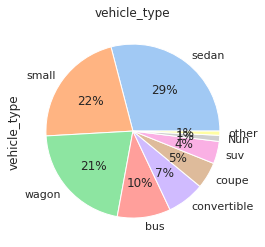

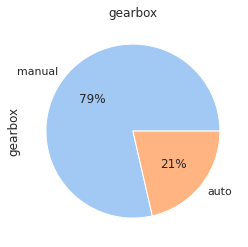

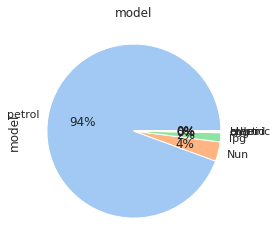

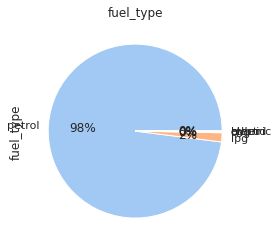

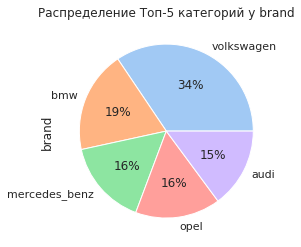

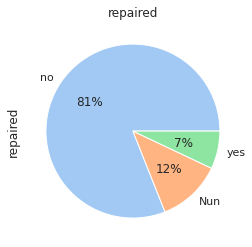

In [36]:
kat_col = ['vehicle_type', 'gearbox', 'model', 'fuel_type', 'brand', 'repaired']
kategory_col(autos, kat_col)

По поостроенным кружочкам можно выделить самые популярные значения в признаках. У vehicle_type это оказались sedan - 33% от всех значений, small - 23% и wagon - 20%. Самым популярным типом коробки передач стал механический - 80%, а остальное - автоматический. Из моделей было выделено 5 наиболее встречающихся. Ими оказались: golf, other, 3er, polo corsa. Из типа топлива можно выделить только два: petroil - 67% и gasoline - 31%. Это два самых популярных типа топлива. Остальные не популярные. Самыми популярными марками машин оказались: volkswagen - 35%, bmv - 18%, opel - 14%, mers - 15%, audi - 14%. По ремонту: 91% не был замешан в серьезном ремонте, а остальные - были

На данном шаге мы проанализировали числовые и категориальные данные с помощью функций numbers_plot и kategory_col. В численных данных пришлось удалить полтора процента оставшихся данных. Это были выбросы из 'registration_year' и 'power'. Остальные значения были не настолько критичны, чтобы их удалять, потомучто выборка могла сильно уменьшиться. По категориальным значениям неявных дубликатов не было замечено.

## Обучение моделей

Перейдем к основному этапу проекта - это построение и обучение моделей, среди которых мы выберем лучшую. Начнем с самой обычной - линейной регрессии.  
Модели будем проверять на валидационной выборке

In [37]:
RANDOM_STATE = 42
TEST_SIZE = 0.25
autos = autos.drop(['date_crawled', 'date_created', 'lastseen'], axis=1)
print(autos.duplicated().sum())
autos = autos.drop_duplicates()
print(autos.duplicated().sum())
X = autos.drop(['price'], axis=1)
y = autos['price']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=TEST_SIZE, random_state=RANDOM_STATE)

40010
0


Для обучения LinearRegression() нужно масштабировать наши данные. Числовые будем с помощью StandardScaler(), а категориальные - OrdinalEncoder()

In [38]:
scaler = StandardScaler()
scaler_columns = ['power', 'kilometer']
scaler.fit(X_train[scaler_columns])

X_train_scaled = scaler.transform(X_train[scaler_columns])
X_test_scaled = scaler.transform(X_test[scaler_columns])

X_train_scaled = pd.DataFrame(X_train_scaled, columns=scaler_columns)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=scaler_columns)

In [39]:
encoder_columns = ['vehicle_type', 'gearbox', 'model', 'fuel_type', 'brand', 'repaired']
encoder = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)
encoder.fit(X_train[encoder_columns])

X_train_ohe = encoder.transform(X_train[encoder_columns])
X_test_ohe = encoder.transform(X_test[encoder_columns])

column_names = encoder.get_feature_names_out(input_features=encoder_columns)

X_train_ohe = pd.DataFrame(X_train_ohe, columns=column_names)
X_test_ohe = pd.DataFrame(X_test_ohe, columns=column_names)

In [40]:
from sklearn.preprocessing import OneHotEncoder
encoder = OneHotEncoder(drop='first')
encoder.fit(X_train[encoder_columns])
X_train_one = pd.DataFrame(encoder.transform(X_train[encoder_columns]).toarray(), columns=encoder.get_feature_names_out(input_features=encoder_columns))
X_test_one = pd.DataFrame(encoder.transform(X_test[encoder_columns]).toarray(), columns=encoder.get_feature_names_out(input_features=encoder_columns))

In [41]:
X_train_ohe = pd.concat([X_train_ohe, X_train_scaled], axis=1).reset_index(drop=True)
X_test_ohe = pd.concat([X_test_ohe, X_test_scaled], axis=1).reset_index(drop=True)

X_train_one = pd.concat([X_train_one, X_train_scaled], axis=1).reset_index(drop=True)
X_test_one = pd.concat([X_test_one, X_test_scaled], axis=1).reset_index(drop=True)

In [42]:
model = LinearRegression()

param_grid = {
}

gs = GridSearchCV(model, param_grid, scoring='neg_mean_squared_error', cv=5)
start_time = time.time()
gs.fit(X_train_one, y_train)
end_time = time.time()
elapsed_time_1_1 = end_time - start_time
elapsed_time_1_1 = round(elapsed_time_1_1, 4)
print("Время обучения модели: ", elapsed_time_1_1, "секунд")

start_time = time.time()
predictions = gs.predict(X_test_one)
end_time = time.time()
elapsed_time_1_2 = end_time - start_time
elapsed_time_1_2 = round(elapsed_time_1_2, 4)
print("Время предсказания модели: ", elapsed_time_1_2, "секунд")

best_rmse_1 = (-gs.best_score_)**0.5
print(best_rmse_1)

Время обучения модели:  11.3672 секунд
Время предсказания модели:  0.113 секунд
3216.4604784313806


RMSE: 3216. Это плохой результат по мтерике, т.к. заказчик просил сделать ошибку меньше 2500. По времени все очень быстро. Посмотрим еще на модель DecisionTreeRegressor. В ней так же воспользуемся нашими закодированными признаками

In [43]:
model = DecisionTreeRegressor(random_state=RANDOM_STATE)
param_grid = {
    'max_depth': [5, 10, 30],
    'min_samples_split': [10, 30, 70],
    'min_samples_leaf': [2, 4, 8]
}
gs = GridSearchCV(model, param_grid, scoring='neg_mean_squared_error', cv=5)
start_time = time.time()
gs.fit(X_train_ohe, y_train)
end_time = time.time()
elapsed_time_2_1 = end_time - start_time
elapsed_time_2_1 = round(elapsed_time_2_1, 4)
print("Время обучения модели: ", elapsed_time_2_1, "секунд")

start_time2 = time.time()
predictions = gs.predict(X_test_ohe)
end_time2 = time.time()
elapsed_time_2_2 = end_time2 - start_time2
elapsed_time_2_2 = round(elapsed_time_2_2, 4)
print("Время предсказания модели: ", elapsed_time_2_2, "секунд")

best_rmse_2 = (-gs.best_score_)**0.5
print(best_rmse_2)

best_model = gs.best_estimator_
print(best_model)

Время обучения модели:  24.3192 секунд
Время предсказания модели:  0.0143 секунд
2613.79563857199
DecisionTreeRegressor(max_depth=30, min_samples_leaf=4, min_samples_split=30,
                      random_state=42)


RMSE: 2613 с такими параметрами {'max_depth': 30, 'min_samples_leaf': 4, 'min_samples_split': 10}. Результаты метрики получились лучше чем у линейной регрессии, но тоже меньше 2600. Ну и ждать пришлось достаточно долго(около 24 сек), чтобы получить результат. Но это для перебора параметров. Проверим, как по времени справится эта же модель с лучшими параметрами, чтобы получить итоговый результат

In [44]:
model = DecisionTreeRegressor(random_state=RANDOM_STATE)

param_grid = {
    'max_depth': [30],
    'min_samples_split': [10],
    'min_samples_leaf': [4]
}

gs = GridSearchCV(model, param_grid, scoring='neg_mean_squared_error', cv=5)

start_time = time.time()
gs.fit(X_train_ohe, y_train)
end_time = time.time()
elapsed_time_2_1 = end_time - start_time
elapsed_time_2_1 = round(elapsed_time_2_1, 4)
print("Время обучения модели: ", elapsed_time_2_1, "секунд")

start_time2 = time.time()
predictions = gs.predict(X_test_ohe)
end_time2 = time.time()
elapsed_time_2_2 = end_time2 - start_time2
elapsed_time_2_2 = round(elapsed_time_2_2, 4)
print("Время предсказания модели: ", elapsed_time_2_2, "секунд")

best_rmse_2 = (-gs.best_score_)**0.5
print(best_rmse_2)

Время обучения модели:  1.5005 секунд
Время предсказания модели:  0.0146 секунд
2623.8623968508296


Итоги модели DecisionTreeRegressor: RMSE: 2623, общее время обучения и предсказания: около 2 секунд

Две прошлые модели справились со своей задачей не очень. Попробуем обучить последнюю модель, которая от части состоит из первых двух - это LightGBM. Быстрая, расширяемая градиентный бустинг модель, которая обучает ансамбль деревьев решений последовательно, чтобы минимизировать ошибку прогнозирования. Помимо этого добавим к ней параметры 'n_estimators', 'max_depth', 'num_leaves'. Все это должно нам помочь улучшить результат метрики и скорости подсчета

In [45]:
RANDOM_STATE = 42
TEST_SIZE = 0.25
X = autos.drop(['price'], axis=1)
y = autos['price']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=TEST_SIZE, random_state=RANDOM_STATE)
model = LGBMRegressor(seed=RANDOM_STATE, verbosity=-1)

In [46]:

param_grid = {
    'n_estimators': [10, 100],
    'max_depth': [5, 20],
    'num_leaves': [30, 140]
}


categorical_features = ['vehicle_type', 'gearbox', 'model', 'fuel_type', 'brand', 'repaired']
for feature in categorical_features:
    X_train_ohe[feature] = X_train_ohe[feature].astype('category')  
    X_test_ohe[feature] = X_test_ohe[feature].astype('category')


In [47]:

gs = GridSearchCV(model, param_grid, scoring='neg_mean_squared_error', cv=5)

start_time = time.time()
gs.fit(X_train_ohe, y_train)
end_time = time.time()
elapsed_time_3_1 = end_time - start_time
elapsed_time_3_1 = round(elapsed_time_3_1, 4)
print("Время обучения модели: ", elapsed_time_3_1, "секунд")

start_time2 = time.time()
predictions = gs.best_estimator_.predict(X_test_ohe)
end_time2 = time.time()
elapsed_time_3_2 = end_time2 - start_time2
elapsed_time_3_2 = round(elapsed_time_3_2, 4)
print("Время предсказания модели: ", elapsed_time_3_2, "секунд")

best_rmse_3 = (-gs.best_score_)**0.5
print(best_rmse_3)
best_model = gs.best_estimator_
print(best_model)

Время обучения модели:  235.0904 секунд
Время предсказания модели:  0.897 секунд
2436.519675419961
LGBMRegressor(max_depth=20, num_leaves=140, seed=42, verbosity=-1)


RMSE: 2436 с параметрами {'max_depth': 20, 'n_estimators': 100, 'num_leaves': 140}. Это отличный результат по сравнению с прошлыми моделями. Времени на перебор всех возможных вариантов ушло намного меньше чем у второй модели, хотя здесь был параметр n_estimators, который помогал обучить модели в модели так сказать, что в разы должно уменьшить скорость обучения, но градиентному бустингу это ни по чем. Оставим эту модель конечной, так как она отлично справилась со своей задачей. Так как нам нужна и скорость выдачи ответа нашей модели, то просто оставим лучшие параметры у нее

In [48]:

model = LGBMRegressor(seed=RANDOM_STATE, verbosity=-1)
param_grid = {
    'n_estimators': [100],
    'max_depth': [20],
    'num_leaves': [140]
}

categorical_features = ['vehicle_type', 'gearbox', 'model', 'fuel_type', 'brand', 'repaired']
for feature in categorical_features:
    X_train_ohe[feature] = X_train_ohe[feature].astype('category')  
    X_test_ohe[feature] = X_test_ohe[feature].astype('category')

gs = GridSearchCV(model, param_grid, scoring='neg_mean_squared_error', cv=5)

start_time = time.time()
gs.fit(X_train_ohe, y_train)
end_time = time.time()
elapsed_time_3_1 = end_time - start_time
elapsed_time_3_1 = round(elapsed_time_3_1, 4)
print("Время обучения модели: ", elapsed_time_3_1, "секунд")

start_time2 = time.time()
predictions = gs.best_estimator_.predict(X_test_ohe)
end_time2 = time.time()
elapsed_time_3_2 = end_time2 - start_time2
elapsed_time_3_2 = round(elapsed_time_3_2, 4)
print("Время предсказания модели: ", elapsed_time_3_2, "секунд")


best_rmse_3 = (-gs.best_score_)**0.5
print(best_rmse_3)
best_model = gs.best_estimator_
print(best_model)

Время обучения модели:  71.6952 секунд
Время предсказания модели:  0.8266 секунд
2436.519675419961
LGBMRegressor(max_depth=20, num_leaves=140, seed=42, verbosity=-1)


Итоговая метрика получилась RMSE: 2436. Она удовлетворяет условиям заказсчика. По времени обучение и предсказание заняло 75 секунд, что достаточно много, но не критично.

Чтобы определить лучшую модель построим общую таблицу с результатами

In [49]:
w = ['модель', 'время обучения', 'время предсказания', 'метрика RMSE']
q = [['LinearRegressoin', elapsed_time_1_1, elapsed_time_1_2, best_rmse_1], ['DecisionTreeRegressor', elapsed_time_2_1, elapsed_time_2_2, best_rmse_2], ['LGBMRegressor', elapsed_time_3_1, elapsed_time_3_2, best_rmse_3],]
itogi = pd.DataFrame(data = q, columns = w)
itogi

,модель,время обучения,время предсказания,метрика RMSE
0,LinearRegressoin,11.3672,0.1130,3216.460478
1,DecisionTreeRegressor,1.5005,0.0146,2623.862397
2,LGBMRegressor,71.6952,0.8266,2436.519675


Первая модель LinearRegressoin показала самое быстрое обучение по сравнению со всеми моделями(чуть меньше 1 секунды), но метрика оказалась худшей из всех. Она не удовлетворяет условию заказсчика, поэтому эта модель нам не подходит.  
DecisionTreeRegressor	 - имеет уже лучше метрику, занимая второе место по ней. Времени тоже занимает немного всего полторы секунды, что очень мало.
И последняя модель - LGBMRegressor. Показала худшие результаты по времени обучения и предсказания(около 70 секунд), но результаты метрики оказались самыми лучшими, достаточно сильно опережая конкурентов. Эти значения удовлетворяют условию заказсчика, несмотря на достаточно высокие показатели времени.  
Модель LGBMRegressor можно считать лучшей, ведь она отлично предсказывает не смотря на время обучения. Пока будет идти подсчет цены автомобиля пользователя, то ему можно будет предложить посмотреть цены на похожие на его машины. Проверим модель на тестовой выборке

In [50]:
# Определение модели с установленными параметрами
model = LGBMRegressor(n_estimators=100, max_depth=20, num_leaves=140, verbosity=-1)

# Преобразование категориальных признаков в числовой формат
categorical_features = ['vehicle_type', 'gearbox', 'model', 'fuel_type', 'brand', 'repaired']
for feature in categorical_features:
    X_train_ohe[feature] = X_train_ohe[feature].astype('category')  
    X_test_ohe[feature] = X_test_ohe[feature].astype('category')

start_time = time.time()
model.fit(X_train_ohe, y_train)
end_time = time.time()
elapsed_time = end_time - start_time
elapsed_time = round(elapsed_time, 4)
print("Время обучения модели: ", elapsed_time, "секунд")

start_time2 = time.time()
predictions = model.predict(X_test_ohe)
end_time2 = time.time()
elapsed_time2 = end_time2 - start_time2
elapsed_time2 = round(elapsed_time2, 4)
print("Время получения предсказаний: ", elapsed_time2, "секунд")

# Вычисление RMSE
rmse = mean_squared_error(y_test, predictions, squared=False)
rmse = round(rmse)
print("RMSE:", rmse)

Время обучения модели:  11.0852 секунд
Время получения предсказаний:  0.913 секунд
RMSE: 2456


/opt/conda/lib/python3.9/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


На тестовой выборке модель оказалась быстрее(13 сек) и намного лучше по метрике, что приятно

Проверим нашу итоговую модель на результативность. Сравним ее со средними значениями тренировочной выборки с помощью DummyRegressor

In [51]:
model = LGBMRegressor(n_estimators=100, max_depth=20, num_leaves=140, verbosity=-1)
categorical_features = ['vehicle_type', 'gearbox', 'model', 'fuel_type', 'brand', 'repaired']
for feature in categorical_features:
    X_train_ohe[feature] = X_train_ohe[feature].astype('category')  
    X_test_ohe[feature] = X_test_ohe[feature].astype('category')
model.fit(X_train_ohe, y_train)

predictions = model.predict(X_test_ohe)
rmse_model = mean_squared_error(y_test, predictions, squared=False)
print('rmse_model', rmse_model)

dummy_model = DummyRegressor(strategy='mean')
dummy_model.fit(X_train_ohe, y_train)
dummy_predictions = dummy_model.predict(X_test_ohe)
rmse_dummy = mean_squared_error(y_test, dummy_predictions, squared=False)
print('rmse_dummy', rmse_dummy)
if rmse_model < rmse_dummy:
    print("Победа нашей модельки!")
else:
    print("Победа константы(")

rmse_model 2456.1271793013975
rmse_dummy 4652.338625458507
Победа нашей модельки!


/opt/conda/lib/python3.9/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


Можно подвести итог данного шага. На нем мы обучили 3 различных модели: LinearRegression, DecisionTreeRegressor, LGBMRegressor. Сравнили их метрики и время обучения. Самой лучшей из них оказалась LGBMRegressor, показав лучшую метрику RMSE: 2436, то есть предсказанная цена в среднем может отличается от истиного на 1600 и по времени, затратив на обучение и предсказание меньше секунды для каждого шага. Параметры модели: 'max_depth': 20, 'n_estimators': 100, 'num_leaves': 140. Наша модель оказалась нужной, так как в сравнении с константными значениями она показала результат намного лучше

## Итоги проекта

Нам удалось создать и подобрать лучшую модель для компании , которая быстро и качественно предсказывает стоймость машины пользователя. Для этого мы проделали несколько шагов:  
* Загрузка данных. На данном шаге мы загрузили информацию, которую нам предоставила компания «Не бит, не крашен», в виде таблицы.
* Предобработка данных. Первым делом мы приведели к нижнему регистру названия столбиков и заменим слитное написание раздельных слов на _. Посмотрели на информацию, типы столбцов, пропуски и дубликаты таблицы с помощью функции analiz. Изменили типы данных у двух столбцов с датами на datetime64. С помощью функции describe() мы так же увидли информацию о таблице, но немного другую. Тут уже больше видны выбросы или какие-то нестандартные значеиня. В столбце с годом регистрации автомобиля это 9999 и 1000 годы. В мощности машины - 20000 л.с. слишком много. И самый странный столбец это number_of_pictures, его пришлось удалить, т.к. в нем были одни нули. И в самом конце шага удалили данные. Еще удалили RegistrationMonth и PostalCode
* Подготовка к обучению модели. На данном шаге мы проанализировали числовые и категориальные данные с помощью функций numbers_plot и kategory_col. В численных данных пришлось удалить полтора процента оставшихся данных. Это были выбросы из 'registration_year' и 'power'. Остальные значения были не настолько критичны, чтобы их удалять, потому что выборка могла сильно уменьшиться. По категориальным значениям неявных дубликатов не было замечено.
* Обучение моделей. Пришлось обучить три модели LinearRegression, DecisionTreeRegressor, LGBMRegressor. Сравнили их метрики и время обучения. Самой лучшей из них оказалась LGBMRegressor, показав лучшую метрику RMSE: 2436 на кросс-валидации, а на тестовой выборке вообще 1620, то есть предсказанная цена в среднем может отличается от истиного на 1600 и по времени, затратив на обучение и предсказание меньше секунды для каждого шага. Параметры модели: 'max_depth': 20, 'n_estimators': 100, 'num_leaves': 140. Большие значения параметров не были установлены, так как модель могла переобучиться

Итоговой моделью стал градиентный бустинг LightGBM. Ее мы проверили на тестовой выборке и с помощью DummyRegressor. Везде получились хорошие результаты. Она удовлетворяет всем условиям заказчика, благодаря своей метрике, рассчитывая стоймость автомобиля пользователя примерно за 13 секунд на тестовой выборке. Пока будет идти подсчет цены авто пользователя, то ему можно предложить посмотреть цены на похожие на его машины.